In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, gaussian_kde
from itertools import permutations

## Main idea

Predict the outcome of a general race game (horse, car, running) using Survival function

We will first sims some data for the race. I will charaterize ecah player by the acceration
$$
a(t)_i = Y_i \sim \mathcal{N}(\mu_i,\sigma_i)
$$
where $Y_i$ it is a Gaussian variable at each instance $t$, like a random walk but for the acceration.

Then we can compute the distance $x(t)$ using the integral
$$
x(t) = \int \left(\int a(t)_i dt \right) dt = \int \left( \int Y_i dt \right) dt  \approx \sum \sum Y_i \Delta t^2
$$

For demostration we set $\Delta t = 1$

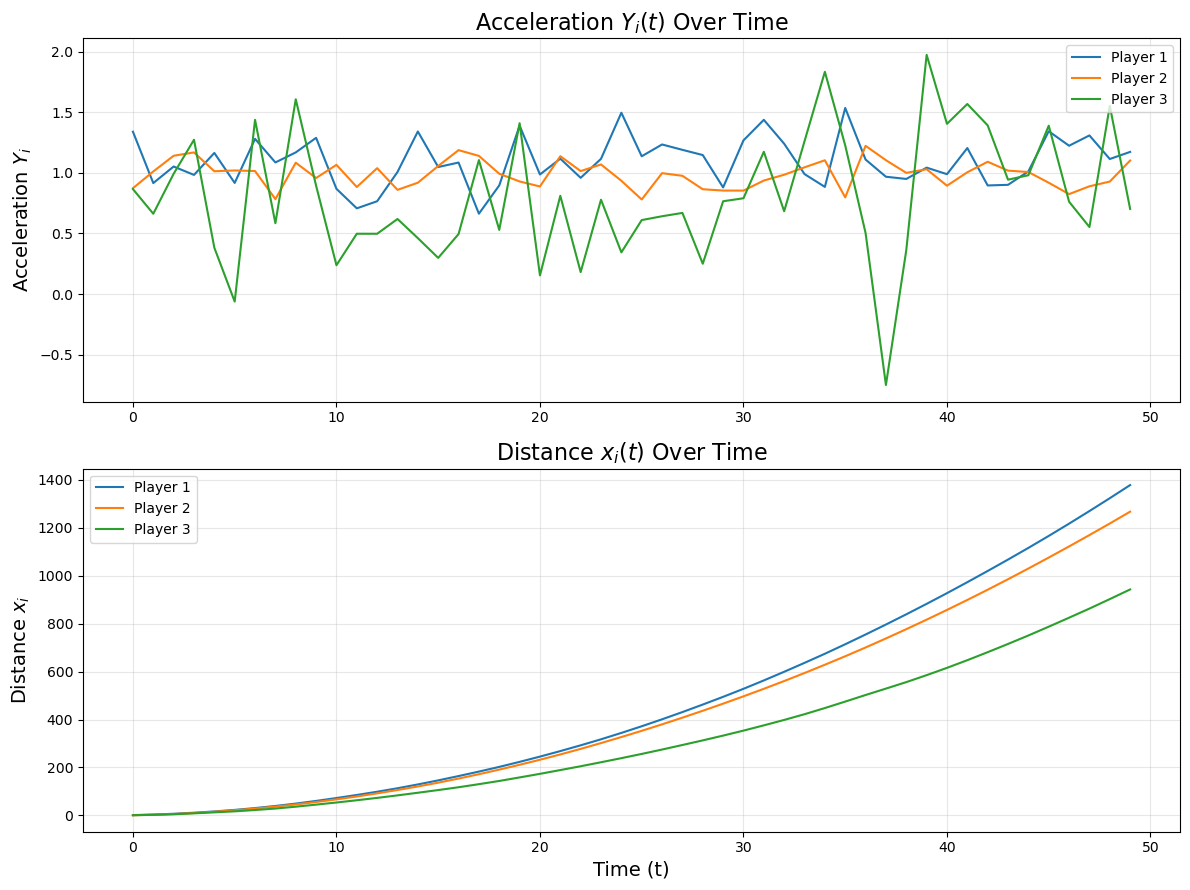

In [5]:
time_steps = 50
mu_values = [1.1, 1, 0.8]
sigma_values = [0.2, 0.1, 0.5]

time = np.arange(time_steps)
accelerations = []

for i in range(len(mu_values)):
    acc = np.random.normal(mu_values[i], sigma_values[i], size=time_steps)
    accelerations.append(acc)

velocities = [np.cumsum(acc) for acc in accelerations]
distances = [np.cumsum(vel) for vel in velocities]

# acceleration
plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
for i, acc in enumerate(accelerations):
    plt.plot(time, acc, label=f'Player {i + 1}')
plt.title('Acceleration $Y_i(t)$ Over Time', fontsize=16)
plt.ylabel('Acceleration $Y_i$', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)

# distance
plt.subplot(2, 1, 2)
for i, dist in enumerate(distances):
    plt.plot(time, dist, label=f'Player {i + 1}')
plt.title('Distance $x_i(t)$ Over Time', fontsize=16)
plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Distance $x_i$', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

We will for each player, generate some sample that repersent their measured acceration plus some noise term
$$
a(t)_{i,\mathrm{data}} = a(t)_i + \epsilon_\epsilon
$$
where $\epsilon \sim \mathcal{N}(0,\sigma_\epsilon)$ is a white noise and $\sigma_\epsilon \propto$ number of player

Let's put a limit to what we can observe. Let's say we can only observe the the postition of the player at each time t and the finishing time (stop time).

In [8]:
def generate_race_data(players, num_races, total_time, goal_distance, eps_para=0.1, dt=0.1):
    """
    Parameters:
        players (dict): Dictionary containing player attributes in the form:
            {
                "player1": {"mu_acc": 1.2, "sigma_acc": 0.1},
                "player2": {"mu_acc": 1.1, "sigma_acc": 0.2},
                ...
            }
        num_races (int): Number of races to simulate.
        total_time (float): Total simulation time.
        goal_distance (float): The same goal distance for all players.
        r (float): Fraction of data to use in the estimator (0 < r <= 1).
        eps_para (float): Parameter controlling the noise sigmoid scaling.
        dt (float): Time step interval for finer resolution.

    Returns:
        results (dict): A dictionary containing:
            {
                "player1": {
                    "distances": list of np.arrays for all races,
                    "stop_times": list of ints (one for each race),
                },
                ...
            }
    """
    def sigmoid(x):
        return 1 / (1 + np.exp(-eps_para * x))

    # Adjust noise scaling based on the number of players
    base_line_sigmoid = sigmoid(1)  # No noise for 1 player
    sigma_epsilon = sigmoid(len(players)) - sigmoid(1)

    time_steps = int(total_time / dt)

    results = {}

    for player_name, attributes in players.items():
        mu_acc = attributes["mu_acc"]
        sigma_acc = attributes["sigma_acc"]

        true_acc_all = []
        noisy_acc_all = []
        distances_all = []
        stop_times = []

        for race in range(num_races):
            true_acc = np.random.normal(mu_acc, sigma_acc, size=time_steps)

            noise = np.random.normal(0, sigma_epsilon, size=time_steps)
            noisy_acc = true_acc + noise

            velocity = np.cumsum(true_acc) * dt
            distance = np.cumsum(velocity) * dt

            stop_time_idx = np.argmax(distance >= goal_distance)
            stop_time = stop_time_idx * dt  # Convert index to time using dt
            true_acc = true_acc[:stop_time_idx]
            noisy_acc = noisy_acc[:stop_time_idx]
            distance = distance[:stop_time_idx]

            true_acc_all.append(true_acc)
            noisy_acc_all.append(noisy_acc)
            distances_all.append(distance)
            stop_times.append(stop_time)

        results[player_name] = {
            "distances": distances_all,
            "stop_times": stop_times,
        }

    return results

In [9]:
def generate_players(num_players=12, mu_start=2, mu_end=1.8, sigma_range=(0.3, 0.9)):
    mu_acc_values = np.linspace(mu_start, mu_end, num_players)
    
    sigma_acc_values = np.random.uniform(sigma_range[0], sigma_range[1], num_players)

    players = {
        f"player{i+1}": {"mu_acc": mu_acc_values[i], "sigma_acc": sigma_acc_values[i]}
        for i in range(num_players)
    }
    
    return players

players = generate_players()

In [10]:
# Race parameters
num_races = 100
total_time = 100  # hard cut off time
goal_distance = 1000  # Same goal distance for all players
r = 0.8  # Fraction of data to sample
dt = 0.1  # Finer time interval

# Generate race data
sampled_data = generate_race_data(players, num_races, total_time, goal_distance, dt=dt)

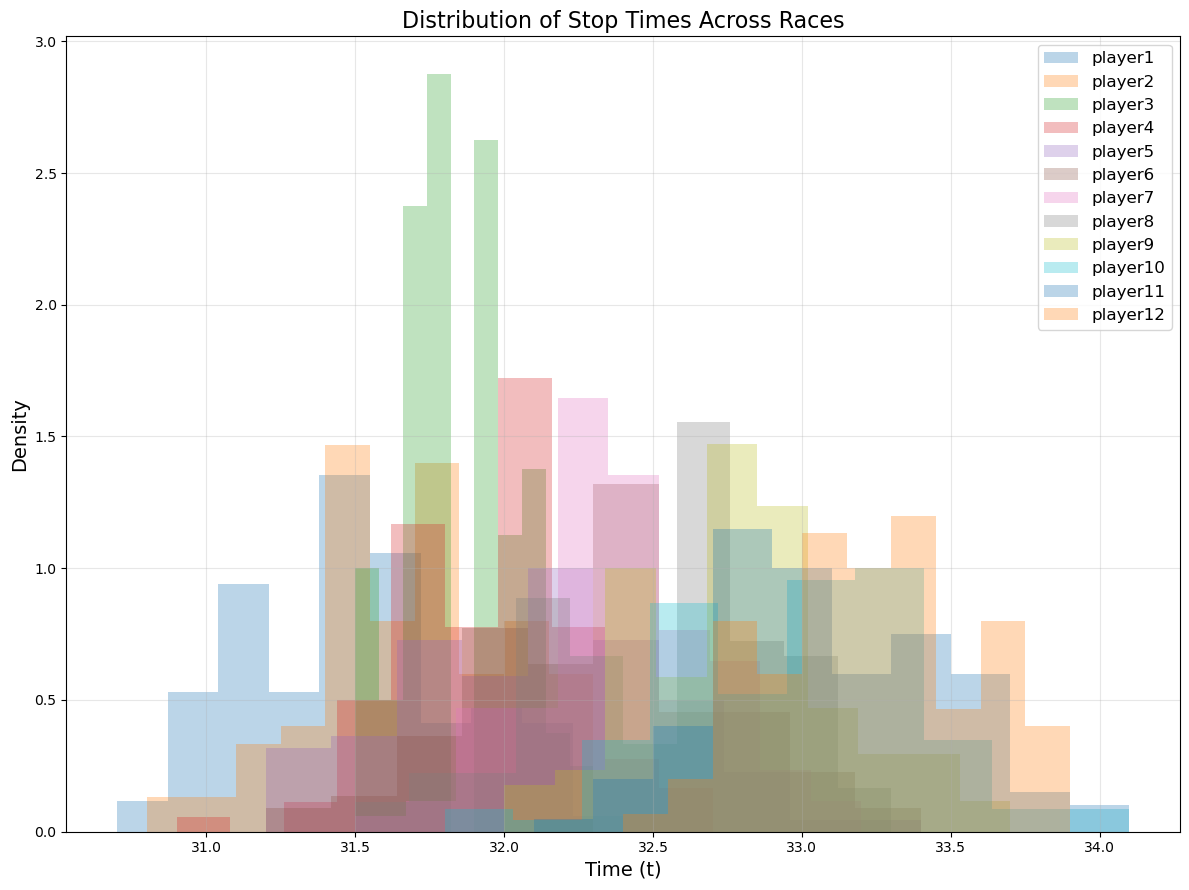

In [11]:
plt.figure(figsize=(12, 9))
for player in sampled_data:
    player_times = sampled_data[player]["stop_times"]
    plt.hist(player_times, label=player, bins=10, density=True, alpha=0.3)

plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.title("Distribution of Stop Times Across Races", fontsize=16)
plt.tight_layout()
plt.show()

Now we have the stopping time distribution for each player. We can then interpert it as an PDF $f(t)$ and calculate the Survival Function $S(t)$ using
$$
S(t) = 1-F(t)
$$
where $F(t)$ is the CDF of $f(t)$. This should be interpert as the probability of player X NOT finishing the race by time t.

In [13]:
def compute_survival_function(sampled_data, bins=100):
    player_survival_estimate = {}

    for player in sampled_data:
        stopping_times = sampled_data[player]["stop_times"]
        
        # Estimate PDF using kernel density estimation (KDE)
        kde = gaussian_kde(stopping_times)
        t = np.linspace(min(stopping_times), max(stopping_times), bins)
        pdf = kde(t)  # PDF values

        # Compute the CDF by integrating the PDF
        cdf = np.cumsum(pdf) * (t[1] - t[0])  # Numerical integration

        # Compute the survival function (1 - CDF)
        survival = 1 - cdf

        # Store results for this player
        player_survival_estimate[player] = {
            "survival": survival,
            "time": t,
            "PDF": pdf,
            "CDF": cdf
        }
        
    return player_survival_estimate

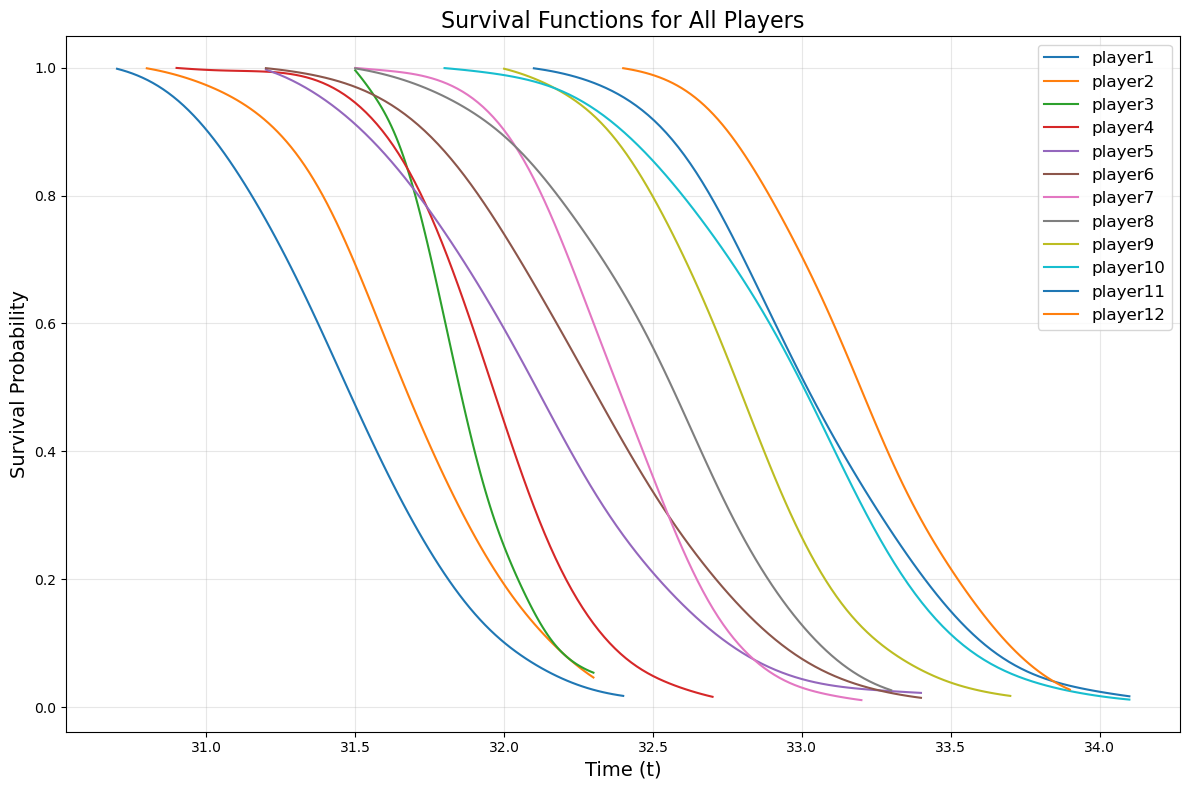

In [14]:
survival_estimates = compute_survival_function(sampled_data)

plt.figure(figsize=(12, 8))
for player in survival_estimates:
    survival = survival_estimates[player]["survival"]
    time = survival_estimates[player]["time"]
    plt.plot(time, survival, label=player)

plt.xlabel("Time (t)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Functions for All Players", fontsize=16)
plt.legend(fontsize=12, loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Now to the prediction. To estimate the probaiblity of player A finishing earlier than player B, we compute
$$
P(T_A<T_B) = \int P(T_B=t) \cdot P(T_B>t) dt
$$

In [16]:
def compute_ranking_probability(survival_functions, bins=100):
    players = list(survival_functions.keys())
    ranking_probabilities = {player: {} for player in players}

    time_grid = survival_functions[players[0]]["time"]
    dt = time_grid[1] - time_grid[0]  # Time step

    for i, player_a in enumerate(players):
        for j, player_b in enumerate(players):
            if player_a == player_b:
                ranking_probabilities[player_a][player_b] = 0.0  # No self-ranking
            else:
                # Get Player A's PDF and Player B's Survival Function
                pdf_a = survival_functions[player_a]["PDF"]
                survival_b = survival_functions[player_b]["survival"]

                # Compute P(T_A < T_B)
                prob_a_wins = np.sum(pdf_a * survival_b * dt)
                ranking_probabilities[player_a][player_b] = prob_a_wins

    return ranking_probabilities

In [17]:
def compute_plackett_luce_probabilities(survival_functions, bins=100):
    players = list(survival_functions.keys())
    ranking_probabilities = {player: {} for player in players}

    time_grid = survival_functions[players[0]]["time"]
    dt = time_grid[1] - time_grid[0]

    # Calculate strength parameters for each player
    # Using mean survival time as a proxy for player strength
    player_strengths = {}
    for player in players:
        pdf = survival_functions[player]["PDF"]
        mean_survival = np.sum(time_grid * pdf * dt)
        player_strengths[player] = np.exp(mean_survival)  # Use exponential to ensure positive values

    # Calculate pairwise probabilities using Plackett-Luce model
    for player_a in players:
        for player_b in players:
            if player_a == player_b:
                ranking_probabilities[player_a][player_b] = 0.0
            else:
                # P(a > b) = strength_a / (strength_a + strength_b)
                prob_a_wins = player_strengths[player_a] / (player_strengths[player_a] + player_strengths[player_b])
                ranking_probabilities[player_a][player_b] = prob_a_wins

    return ranking_probabilities, player_strengths

In [18]:
ranking_probabilities = compute_ranking_probability(survival_estimates)

In [41]:
ranking_PL_probabilities, player_strengths = compute_plackett_luce_probabilities(survival_estimates)

But this is still pair-wise ranking, what we want is to predict the outcome of the ranking of the race. For example, the probability of the outcome being $T_A<T_B<T_C<T_D$, A specific ranking $R = [P_A,P_B,P_C,P_D]$.

We assume the probabilities are indepent to simplify the problem, and use the joint probability(without normalization)
$$
P_\mathrm{raw}(R) = \left[P(T_A<T_B) \cdot P(T_A<T_C) \cdot P(T_A<T_D)\right] \cdot \left[ \cdot P(T_B<T_C) \cdot P(T_B<T_D)\right] \cdot \left[ \cdot P(T_C<T_D)\right]
$$
The final formula is
$$
P(R) = \frac{P_\mathrm{raw}(R)}{\sum_{R} P_\mathrm{raw}(R)},
$$
where
$$
P_\mathrm{raw}(R) = \prod_{i < j}^{4} P(T_i<T_j).
$$

In [47]:
def compute_ranking_combination_probabilities(ranking_probabilities, top_n=4):
    players = list(ranking_probabilities.keys())
    top_players = players[:top_n]
    all_rankings = list(permutations(top_players))
    
    ranking_combination_probs = {}

    for ranking in all_rankings:
        prob = 1.0
        for i in range(len(ranking)):
            for j in range(i + 1, len(ranking)):
                player_a = ranking[i]
                player_b = ranking[j]
                prob *= ranking_probabilities[player_a][player_b]
        ranking_combination_probs[ranking] = prob

    # Normalize the probabilities
    total_prob = sum(ranking_combination_probs.values())
    for ranking in ranking_combination_probs:
        ranking_combination_probs[ranking] /= total_prob

    return ranking_combination_probs

In [49]:
ranking_combination_probs = compute_ranking_combination_probabilities(ranking_probabilities, top_n=4)

top_3_outcomes = sorted(ranking_combination_probs.items(), key=lambda x: x[1], reverse=True)[:3]

print('Top 3 outcome')
for ranking, prob in top_3_outcomes:
    print(f"P{ranking} = {prob:.4f}")

Top 3 outcome
P('player3', 'player1', 'player2', 'player4') = 0.2053
P('player3', 'player1', 'player4', 'player2') = 0.1635
P('player3', 'player2', 'player1', 'player4') = 0.1250


In [51]:
ranking_combination_probs_PL = compute_ranking_combination_probabilities(ranking_PL_probabilities, top_n=4)

top_3_outcomes_PL = sorted(ranking_combination_probs_PL.items(), key=lambda x: x[1], reverse=True)[:3]

print('Top 3 outcome(PL)')
for ranking, prob in top_3_outcomes:
    print(f"P{ranking} = {prob:.4f}")

Top 3 outcome(PL)
P('player3', 'player1', 'player2', 'player4') = 0.2053
P('player3', 'player1', 'player4', 'player2') = 0.1635
P('player3', 'player2', 'player1', 'player4') = 0.1250


In [53]:
def plot_ranking_probabilities(ranking_combination_probs):
    players = list(set(player for ranking in ranking_combination_probs.keys() for player in ranking))
    ranks = len(players)

    rank_probs = {rank: {player: 0.0 for player in players} for rank in range(1, ranks + 1)}

    for ranking, prob in ranking_combination_probs.items():
        for rank, player in enumerate(ranking):
            rank_probs[rank + 1][player] += prob

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    colors = plt.cm.tab10(np.arange(len(players)))

    for rank in range(1, ranks + 1):
        ax = axes[(rank - 1) // 2, (rank - 1) % 2]
        players_in_rank = list(rank_probs[rank].keys())
        probabilities = list(rank_probs[rank].values())
        ax.bar(players_in_rank, probabilities, color=colors)
        ax.set_title(f"Rank {rank}", fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Probability" if rank in [1, 3] else "")
        ax.set_xlabel("Players")
        ax.tick_params(axis="x", rotation=45)
        ax.grid(alpha=0.3)

    fig.suptitle("Probability of Each Player Finishing in Each Rank", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

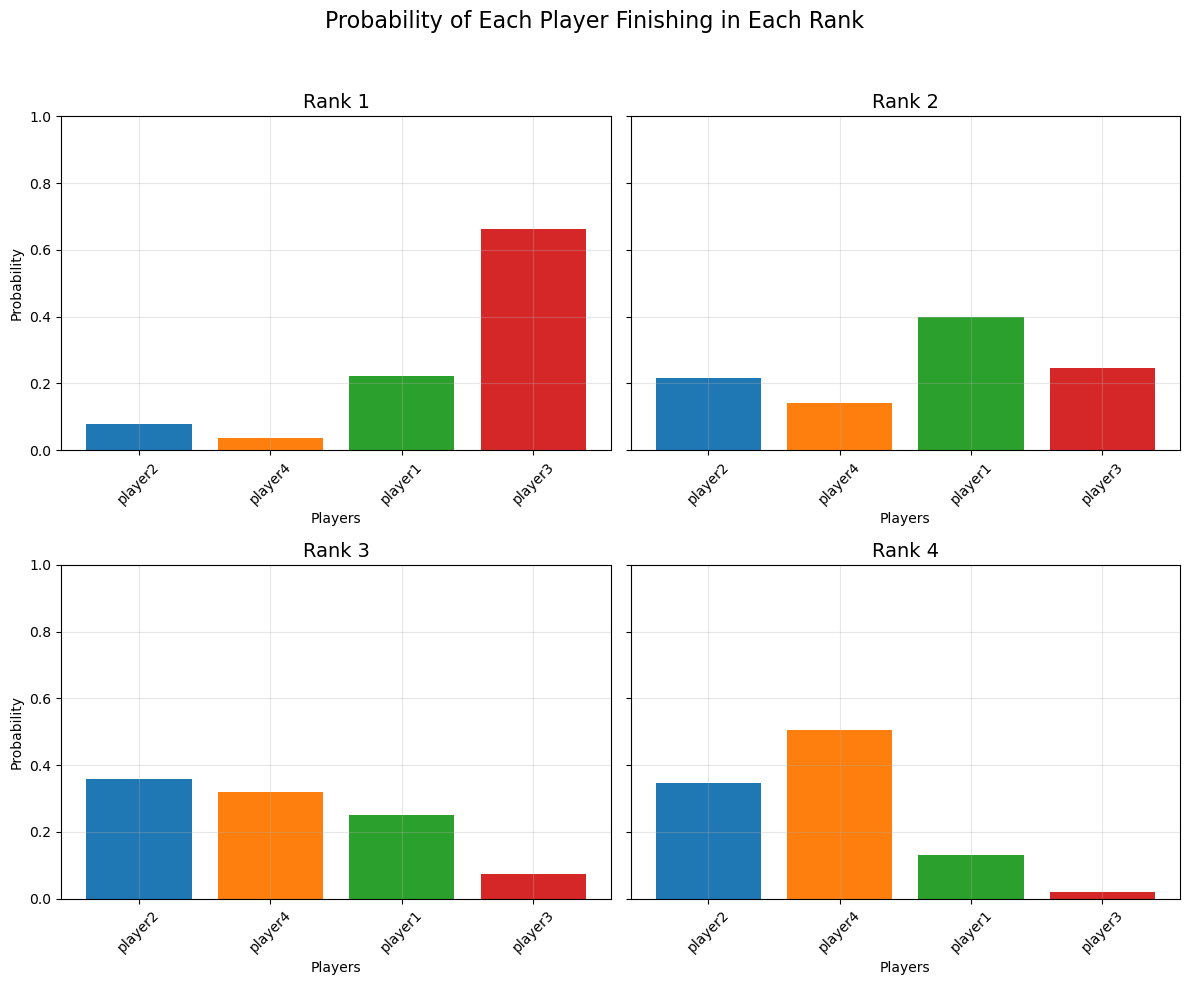

In [55]:
plot_ranking_probabilities(ranking_combination_probs)

This is the simpliest model one can do.